# Ejemplo: 32 MOC3D Problem 1

**Resumen**. 

Se resuelve el problema de flujo en una dimensión usando los datos del ejemplo descrito en [1]. 

<p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><a property="dct:title" rel="cc:attributionURL" href="https://github.com/luiggix/mf6_tutorial/">MODFLOW 6: tutorial</a> (2_flow_trans/01_flow_trans_1D.ipynb) by <b>Luis M. de la Cruz Salas (2025)</b> is licensed under <a href="http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">Attribution-ShareAlike 4.0 International<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a>.</p> 


## Discretización del tiempo.

* La simulación consta de un período de estrés que tiene una duración de $120$ $s$.
* El período de estrés se divide en $240$ pasos de tiempo del mismo tamaño.

|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Number of stress periods (NPER) | $1$ | | `tdis["nper"]` |
|Total time | $120$ | s | `tdis["perioddata"][0][0]` |
|Number of time steps (NSTP) | $240$ | | `tdis["perioddata"][0][1]` |
|Multiplier (TSMULT)| $1$ | | `tdis["perioddata"][0][2]` |

## Discretización espacial.

* El modelo de malla consiste de $1$ capa, $120$ columnas y $1$ renglón.
* La longitud del renglón es de $12$ [cm].
* La longitud de la columna es $0.1$ [cm].
* Con la información anterior se calcula el ancho del renglón, `DELC`, y de las columnas, `DELR`, que ambos casos debe ser $0.1$ [cm].
* La parte superior (`TOP`) de la celda es $1.0$ [cm] y la parte inferior (`BOTTOM`) es cero.
* La longitud de la capa es igual a $1.0$ [cm], valor que se calcula de `|TOP - BOTTOM|`.

|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Length of system (rows) | $12.0$ | cm | |
|Number of layers | $1$ | | `dis["nlay"]`|
|Number of rows | $1$ | | `dis["nrow"]`|
|Number of columns | $120$ | | `dis["ncol"]`|
|Column width | $0.1$ | cm | `dis["delr"]`|
|Row width | $0.1$ | cm | `dis["delc"]`|
|Top of the model | $1.0$ | cm | `dis["top"]`|
|Layer bottom elevation (cm) | $0$ | cm | `dis["botm"]`|

## Parámetros físicos.

* Al utilizar un valor de porosidad uniforme de $0.1$, se obtiene un valor de velocidad de $0.1$ $cm/s$ como resultado de la inyección de agua a una velocidad de $0.001$ $cm^3/s$ en la primera celda.
* A la última celda se le asigna una carga constante con un valor de cero, aunque este valor no es importante ya que las celdas están marcadas como confinadas.
* A la concentración del agua inyectada se le asigna un valor de $1.0$, y cualquier agua que salga a través de la celda de carga constante sale con la concentración simulada del agua en esa última celda.
* La advección se resuelve utilizando el esquema **TVD** para reducir la dispersión numérica.
  
|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Specific discharge |0.1| cm s$^{-1}$ | `phys["specific_discharge"]` |
|Hydraulic conductivity |0.01| cm s$^{-1}$ | `phys["hydraulic_conductivity"]` |
|Source concentration |1.0| unitless | `phys["source_concentration"]` |
|Porosity | 0.1 | unitless |  `phys["porosity"]` |
|Initial Concentration | 0.0 | unitless | `phys["initial_concentration"]` |
|Longitudinal Dispersivity | 0.1 |  | `phys["longitudinal_dispersivity"]` |
|Retardation Factor | 1.0 |  | `phys["'retardation_factor"]` |
|Decay Rate | 0.0 |  | `phys["decay_rate"]` |
|Dispersion coefficient | | | `phys["dispersion_coefficient"]` |

$$
\text{Dispersion Coefficient} = \dfrac{\text{Longitudinal Dispersivity} \times \text{Specific Discharge}}{\text{Retardation Factor}}
$$

### Cuatro casos:

<img src="./moc3d.png" width=600px>

# Implementación

## Paso 0. Importación de bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flopy
import os
import xmf6

## Paso 1. Parámetros físicos.

In [2]:
phys = dict(
    specific_discharge = 0.1,  # Specific discharge ($cm s^{-1}$)
    hydraulic_conductivity = 0.01,  # Hydraulic conductivity ($cm s^{-1}$)
    source_concentration = 1.0,  # Source concentration (unitless)
    porosity = 0.1,  # Porosity of mobile domain (unitless)
    initial_concentration = 0.0,  # Initial concentration (unitless)
)
xmf6.nice_print(phys, "Parámetros físicos")


Parámetros físicos
――――――――――――――――――
    specific_discharge = 0.1
hydraulic_conductivity = 0.01
  source_concentration = 1.0
              porosity = 0.1
 initial_concentration = 0.0
――――――――――――――――――


## Paso 2. Simulación del flujo: GWT

In [5]:
# Parámetros de la simulación (flopy.mf6.MFSimulation)
init = {
    'sim_name' : "flow",
    'exe_name' : "C:\\Users\\luiggi\\Documents\\GitSites\\xmf6\\mf6\\windows\\mf6",
#    'exe_name' : "../../mf6/macosarm/mf6",
    'sim_ws' : "output_flow_trans_1D"
}

# Parámetros para el tiempo (flopy.mf6.ModflowTdis)
tdis = {
    'units': "seconds",
    'nper' : 1,
    'perioddata': [(120.0, 240, 1.0)]
}

# Parámetros para la solución numérica (flopy.mf6.ModflowIms)
ims = {}

# Parámetros para el modelo de flujo (flopy.mf6.ModflowGwf)
gwf = { 
    'modelname': init["sim_name"],
    'save_flows': True
}

# Parámetros para la discretización espacial (flopy.mf6.ModflowGwfdis)
dis = {
    'length_units' : "centimeters",
    'nlay': 1, 
    'nrow': 1, 
    'ncol': 120,
    'delr': 0.1, 
    'delc': 0.1, 
    'top' : 1.0, 
    'botm': 0.0 
}

# Parámetros para las condiciones iniciales (flopy.mf6.ModflowGwfic)
ic = {
    'strt': 1.0
}

# Parámetros para las condiciones de frontera (flopy.mf6.ModflowGwfchd)
chd = {
    'stress_period_data': [[(0, 0, dis['ncol'] - 1), 1.0]],     
}

# Parámetros para las propiedades de flujo (flopy.mf6.ModflowGwfnpf)
npf = {
    'save_specific_discharge': True,
    'save_saturation': True,
    'icelltype':  0,
    'k': phys["hydraulic_conductivity"] # Hydraulic conductivity ($cm s^{-1}$) 
}

# Parámetros para las propiedades de los pozos (flopy.mf6.ModflowGwfwel)
q = phys["specific_discharge"] * dis['delc'] * dis['delr'] * dis['top']
well = {
    'stress_period_data': [[(0, 0, 0), q, phys["source_concentration"],]],
    'pname': "WEL-1",
    'auxiliary' : ["CONCENTRATION"],
#    'save_flows': True
}

# Parámetros para almacenar y mostrar la salida de la simulación (flopy.mf6.ModflowGwfoc)
oc = {
    'budget_filerecord': f"{init['sim_name']}.bud",
    'head_filerecord': f"{init['sim_name']}.hds",
    'saverecord': [("HEAD", "ALL"), ("BUDGET", "ALL")],
#    'printrecord': [("HEAD", "ALL")]
}

# --- Inicialización de la simulación ---
o_simf = xmf6.common.init_sim(silent = True, init = init, tdis = tdis, ims = ims)
o_gwf, packages = xmf6.gwf.set_packages(o_simf, silent = True,
                                        gwf = gwf, 
                                        dis = dis, ic = ic, chd = chd, npf = npf, oc = oc, well = well)
# --- Escritura de archivos ---
o_simf.write_simulation(silent = True)

# --- Ejecución de la simulación ---
o_simf.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\mf6\windows\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 10 2025 17:37:25 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Gover

(True, [])

## Paso 3. Simulación del transporte: GWT

Para resolver los cuatro casos definimos la función `get_mst_dict()` que genera la información necesaria para el paquete MST. 


In [8]:
def get_mst_dict(phys):
    mst = dict(
        porosity = phys["porosity"],
        sorption = None,
        bulk_density = None,
        distcoef = None, 
        first_order_decay = None,
        decay = None,
        decay_sorbed = None
    )
    
    if phys["retardation_factor"] > 1.0:
        mst["sorption"] = "linear"
        mst["bulk_density"] = 1.0
        mst["distcoef"] = (phys["retardation_factor"] - 1.0) * phys["porosity"] / mst["bulk_density"]

    if phys["decay_rate"] != 0.0:
        mst["first_order_decay"] = True
        mst["decay"] = phys["decay_rate"]
        if phys["retardation_factor"] > 1.0:
            mst["decay_sorbed"] = phys["decay_rate"]

    return mst

### Determinación de cada caso

In [14]:
long_disp = [0.1, 1.0, 1.0, 1.0]
reta_fact = [1.0, 1.0, 2.0, 1.0]
deca_rate = [0.0, 0.0, 0.0, 0.01]
dir_names = ['p01a','p01b','p01c','p01d']

case = int(input("Caso (1-4)= ")) - 1 # 0, 1, 2, 3
dirname = dir_names[case]

# Agregamos más parámetros físicos al diccionario phys
phys["longitudinal_dispersivity"] = long_disp[case]
phys["retardation_factor"] = reta_fact[case]
phys["decay_rate"] = deca_rate[case]
phys["dispersion_coefficient"] = phys["longitudinal_dispersivity"] * phys["specific_discharge"] / phys["retardation_factor"]

xmf6.nice_print(phys, "Parámetros físicos")
print("Caso: {}".format(dirname))

Caso (1-4)=  2



Parámetros físicos
――――――――――――――――――
       specific_discharge = 0.1
   hydraulic_conductivity = 0.01
     source_concentration = 1.0
                 porosity = 0.1
    initial_concentration = 0.0
longitudinal_dispersivity = 1.0
       retardation_factor = 1.0
               decay_rate = 0.0
   dispersion_coefficient = 0.1
――――――――――――――――――
Caso: p01b


In [15]:
# Parámetros de la simulación (flopy.mf6.MFSimulation)
init_t = {
    'sim_name' : "transport",
    'exe_name' : "C:\\Users\\luiggi\\Documents\\GitSites\\xmf6\\mf6\\windows\\mf6",
#    'exe_name' : "../../mf6/macosarm/mf6",
    'sim_ws' : "output_flow_trans_1D"
}

# Parámetros para el tiempo (flopy.mf6.ModflowTdis)
#El mismo tdis de flow

# Parámetros para la solución numérica (flopy.mf6.ModflowIms)
ims_t = {
    'linear_acceleration': "bicgstab"
}

# Parámetros para el modelo de transporte (flopy.mf6.ModflowGwt)
gwt = { 
    'modelname': init_t["sim_name"],
    'save_flows': True
}

# Parámetros para la discretización espacial (flopy.mf6.ModflowGwtdis)
# El mismo dis de flow

# Parámetros para las condiciones iniciales (flopy.mf6.ModflowGwtic)
ic_t = {
    'strt': 0.0
}

# Parámetros para MST (flopy.mf6.ModflowGwtmst)
mst = get_mst_dict(phys)

# Parámetros para ADV (flopy.mf6.ModflowGwtadv)
adv = {
    "scheme" : "TVD"
}

# Parámetros para DSP (flopy.mf6.ModflowGwtdsp)
dsp = {
    "xt3d_off" : True,
    "alh" : phys["longitudinal_dispersivity"],
    "ath1" : phys["longitudinal_dispersivity"],
}

# Parámetros para FMI (flopy.mf6.ModflowGwtfmi)
fmi = {
    "packagedata" : [("GWFHEAD", f"{init['sim_name']}.hds", None),
                     ("GWFBUDGET", f"{init['sim_name']}.bud", None),
                    ]
}

# Parámetros para SSM (flopy.mf6.ModflowGwtssm)
ssm = {
    "sources" : [["WEL-1", "AUX", "CONCENTRATION"]]
}

# Parámetros para OBS (flopy.mf6.ModflowGwtobs)
obs = {
    "digits" : 10, 
    "print_input" : True, 
    "continuous" : {
        "transporte.obs.csv": [
            ("X005", "CONCENTRATION", (0, 0, 0)),
            ("X405", "CONCENTRATION", (0, 0, 40)),
            ("X1105", "CONCENTRATION", (0, 0, 110)),
        ],
    }
}

# Parámetros para almacenar y mostrar la salida de la simulación (flopy.mf6.ModflowGwtoc)
oc_t = {
    'budget_filerecord': f"{init_t['sim_name']}.bud",
    'concentration_filerecord': f"{init_t['sim_name']}.ucn",
    'saverecord' : [("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
    'printrecord' : [("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
}

# --- Inicialización de la simulación ---
o_sim_t = xmf6.common.init_sim(silent = True, init = init_t, 
                               tdis = tdis, ims = ims_t)
o_gwt, packagest = xmf6.gwt.set_packages(o_sim_t, silent = True,
                                        gwt = gwt, 
                                        dis = dis, ic = ic_t, 
                                        mst = mst, adv = adv, dsp = dsp, fmi = fmi, ssm = ssm, 
                                        oc = oc_t)

o_obs = xmf6.common.set_obs(o_gwt, obs, silent = True)

# --- Escritura de archivos ---
o_sim_t.write_simulation(silent = True)

# --- Ejecución de la simulación ---
o_sim_t.run_simulation(silent = True)

(True, [])

## Paso 4. Análisis de resultados.

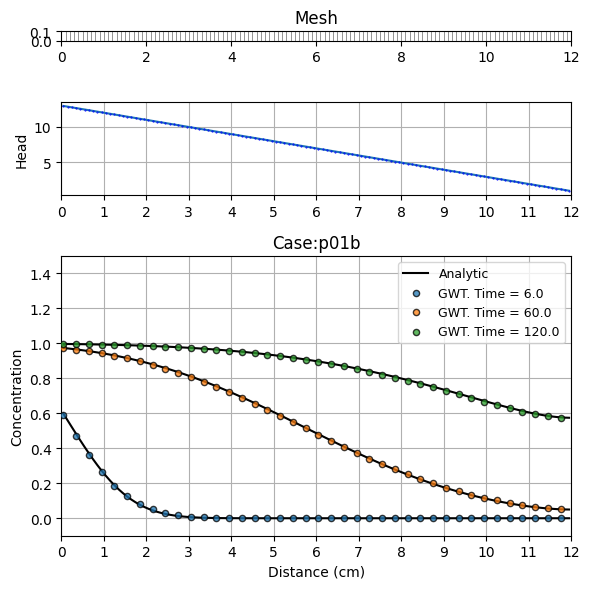

In [16]:
# --- Recuperamos los resultados de flujo de la simulación ---
head = xmf6.gwf.get_head(o_gwf)
qx, qy, qz, n_q = xmf6.gwf.get_specific_discharge(o_gwf, text="DATA-SPDIS")

# --- Recuperamos las coordenadas del dominio
x, y, z = o_gwf.modelgrid.xyzcellcenters
row_length = o_gwf.modelgrid.extent[1]

#--- Leemos la solución analítica de la ec. de transporte ---
sol_path = 'analytic/' + dirname
a1_0 = np.load(sol_path + '/a1_x_0.npy')
a1_1 = np.load(sol_path + '/a1_x_1.npy')
a1_2 = np.load(sol_path + '/a1_x_2.npy')

# --- Definición de la figura ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize =(6,6), height_ratios=[0.1,1,3])

# --- Gráfica 1. Malla ---
pmv = flopy.plot.PlotMapView(o_gwf, ax=ax1)
pmv.plot_grid(colors='dimgray', lw=0.5)
ax1.set_yticks(ticks=[0, 0.1])#, fontsize=8)
ax1.set_title("Mesh")

# --- Gráfica 2. Carga hidráulica---
ax2.plot(x[0], head[0, 0], marker=".", ls ="-", mec="blue", mfc="none", markersize="1", label = 'Head')
ax2.set_xlim(0, 12)
ax2.set_xticks(ticks=np.linspace(0, row_length,13))
#ax2.set_xlabel("Distance (cm)")
ax2.set_ylabel("Head")
ax2.grid()

# --- Gráfica 3. Concentración ---
# Solución analítica
ax3.plot(x[0], a1_0, c = 'k', label='Analytic')
ax3.plot(x[0], a1_1, c = 'k')
ax3.plot(x[0], a1_2, c = 'k')

# Solución numérica
citer = [11, 119, 239]
ctimes = [6.0, 60.0, 120.0]
iskip = 3
for c, (i, t) in enumerate(zip(citer, ctimes)):
    gwt_conc = xmf6.gwt.get_concentration(o_sim_t, t)
    ax3.scatter(x[0][::iskip], gwt_conc[::iskip], label=f'GWT. Time = {t}',
                ec="k", alpha=0.75, s=20, zorder=5)    
    
# Decoración de la gráfica
ax3.legend(fontsize=9)
ax3.set_xlim(0, 12)
ax3.set_ylim(-0.1, 1.5)
ax3.set_xticks(ticks=np.linspace(0, row_length,13))
ax3.set_xlabel("Distance (cm)")
ax3.set_ylabel("Concentration")
ax3.grid(True)
ax3.set_title(f"Case:{dirname}")
plt.tight_layout()
plt.show()